In [2]:
# go to the root directory
# %cd /home/studio-lab-user/701-simplicity-bias
# %cd D:/repos/701-simplicity-bias
%cd /home/studio-lab-user/701-simplicity-bias
import os

assert os.path.exists('./trainers/trainer.py')

/home/studio-lab-user/701-simplicity-bias


In [4]:
%load_ext autoreload
%autoreload 2
import torch
from trainers import Trainer
import datetime
from logging import Logger, StreamHandler

In [6]:
import numpy as np
from synthetic_data.linear_slabs import LinearSlabDataset

In [7]:
data_config = dict(
    num_samples=110000,
    num_dim=50,
    margin=0.1,
    width=1.0,
    random_orthonormal_transform=True
)


ms_57_noisy_02_config = {**data_config, **{'slabs': np.array([5] + [7] * 49), 'noise_proportions': np.array([0.2] + [0] * 49),
                                       'slab_probabilities': [[0.125, 0.5, 0.75, 0.5, 0.125]] +
                                                         [[1/16.0, 0.25, 7 / 16.0, 0.5, 7 / 16.0, 0.25, 1 / 16.0]] * 49}}

ms_57_noisy_03_config = {**data_config, **{'slabs': np.array([5] + [7] * 49), 'noise_proportions': np.array([0.3] + [0] * 49),
                                       'slab_probabilities': [[0.125, 0.5, 0.75, 0.5, 0.125]] +
                                                         [[1/16.0, 0.25, 7 / 16.0, 0.5, 7 / 16.0, 0.25, 1 / 16.0]] * 49}}

ms_57_noisy_04_config = {**data_config, **{'slabs': np.array([5] + [7] * 49), 'noise_proportions': np.array([0.4] + [0] * 49),
                                       'slab_probabilities': [[0.125, 0.5, 0.75, 0.5, 0.125]] +
                                                         [[1/16.0, 0.25, 7 / 16.0, 0.5, 7 / 16.0, 0.25, 1 / 16.0]] * 49}}

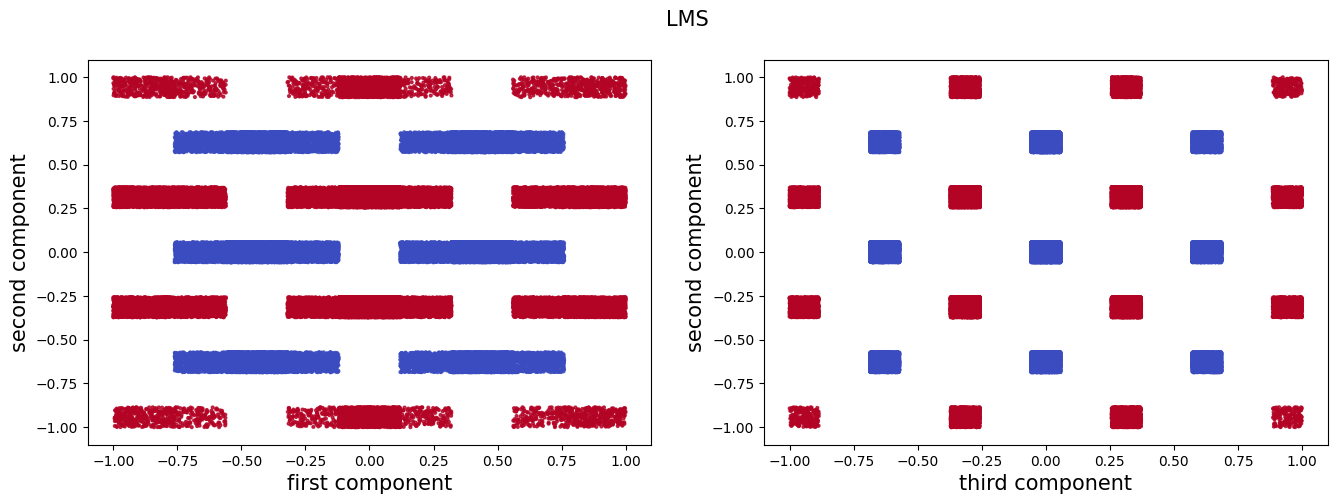

In [8]:
ms_57_noisy_02_data = LinearSlabDataset.generate(**ms_57_noisy_02_config)
ms_57_noisy_02_data.visualize()

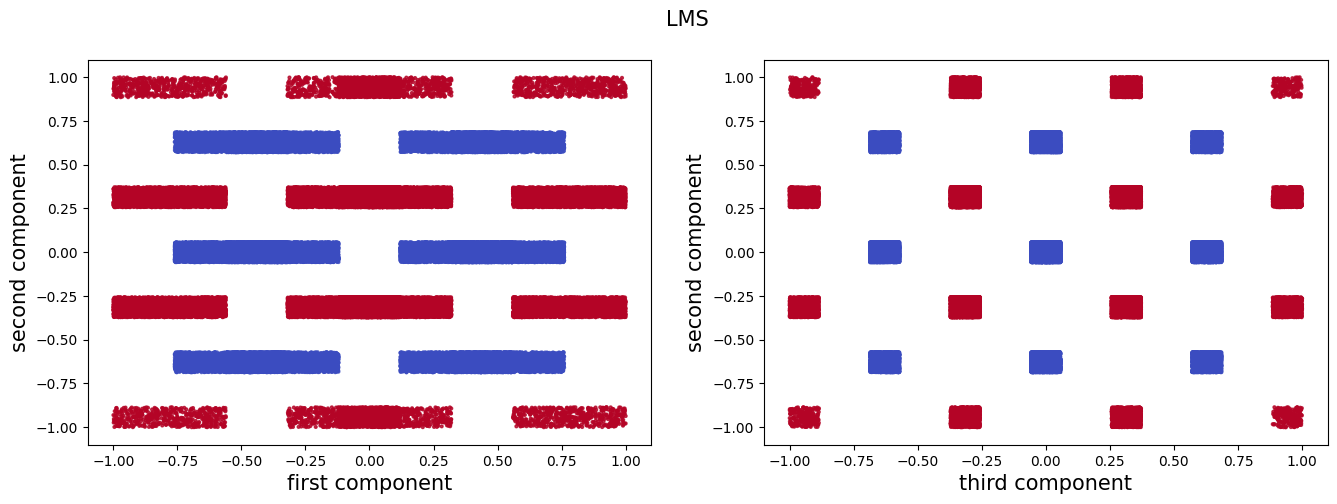

In [9]:
ms_57_noisy_03_data = LinearSlabDataset.generate(**ms_57_noisy_03_config)
ms_57_noisy_03_data.visualize()

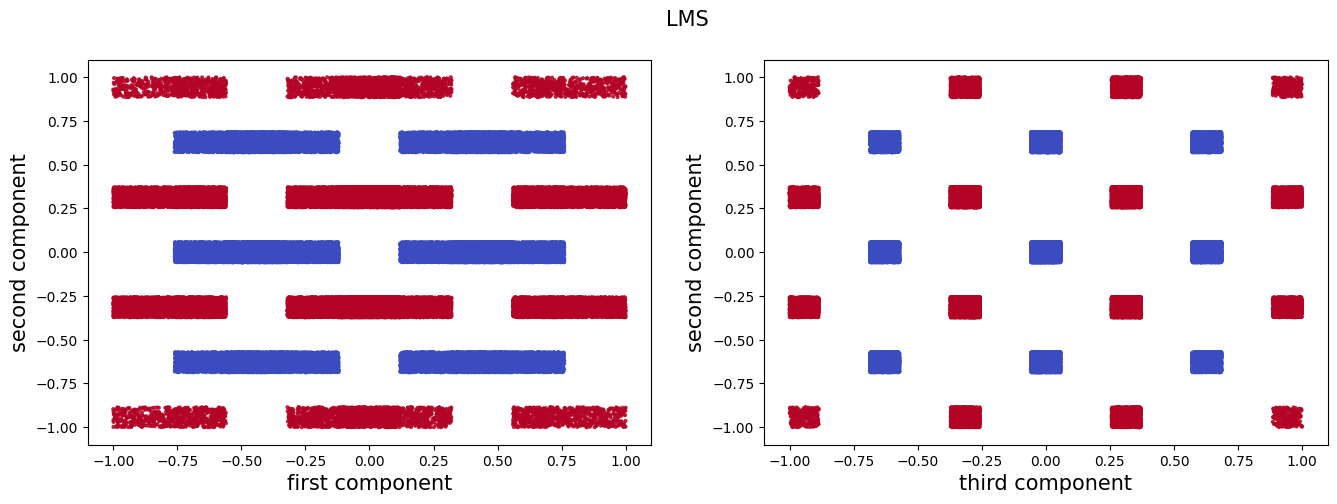

In [10]:
ms_57_noisy_04_data = LinearSlabDataset.generate(**ms_57_noisy_04_config)
ms_57_noisy_04_data.visualize()

In [11]:
#@title train/val split and save linear data
os.makedirs('./data', exist_ok=True)
data_dir = os.path.abspath('./data')
print('Saving Data to {}'.format(data_dir))
train_size = 100000
for name, data, train_size in [
    ('ms57_noisy_02', ms_57_noisy_02_data, 100000),
    ('ms57_noisy_03', ms_57_noisy_03_data, 100000),
    ('ms57_noisy_04', ms_57_noisy_04_data, 100000),
]:
    path = os.path.join(data_dir, name)
    data.save_as(path, train_size)

Saving Data to /home/studio-lab-user/701-simplicity-bias/data


In [12]:
# follow the config of original paper

model_config = dict(
    cls='fcn',
    num_layers=2,
    input_dim=50,
    output_dim=2,
    latent_dim=300,
    use_bn=False,
    dropout_probability=0.0,
    linear_init=None
)

### p=0.2

In [14]:
trainer_logger = Logger('trainer')
trainer_logger.setLevel('DEBUG')
trainer_logger.addHandler(StreamHandler())
trainer_config = dict(
    train_data=dict(
        dataset=dict(
            cls='linear_slabs',
            data_path='./data/ms57_noisy_02_train.npz'
        ),
        batch_size=256,
        shuffle=True
    ), val_data=dict(
        dataset=dict(
            cls='linear_slabs',
            data_path='./data/ms57_noisy_02_val.npz'
        ),
        batch_size=256,
        shuffle=False
    ),
    additional_data=dict(
        s_randomized=dict(
            dataset=dict(
                cls='linear_slabs',
                data_path='./data/ms57_noisy_02_train.npz',
                randomized_axes=(0,)
            ),
            batch_size=256,
            shuffle=False
        ),
        sc_randomized=dict(
            dataset=dict(
                cls='linear_slabs',
                data_path='./data/ms57_noisy_02_train.npz',
                randomized_axes=tuple(range(1, 50))
            ),
            batch_size=256,
            shuffle=False
        )
    ),
    model=model_config,
    loss=dict(cls='CE'),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    evaluate_interval=1000,
    save_interval=0,
    work_dir='./training_logs/ms57_noisy_02_{}/'.format(datetime.datetime.now().strftime('%m%d%H%M')),
    loss_eps=1e-2,
    # accuracy_threshold=0.995,
    logger=trainer_logger,
    max_steps=100000,
    optimizer=dict(
        cls='SGD',
        lr=0.1,
        weight_decay=5.0e-4,
        momentum=0.9
    )
)
trainer = Trainer(**trainer_config)

model: Sequential(
  (0): Linear(in_features=50, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=2, bias=True)
)


In [15]:
trainer.run()

Step 0: Loss 0.6952354907989502
Evaluating ...


Started, logging to ./training_logs/ms57_noisy_02_10291453/...


Step: 0
Train/AUC: 0.49973566489766563
Train/AverageLoss: 0.6934564959335328
Train/Accuracy: 0.5002800226211548
Val/AUC: 0.49925033202124935
Val/AverageLoss: 0.6933484037399292
Val/Accuracy: 0.5004000067710876
s_randomized/AUC: 0.5001327505588917
s_randomized/AverageLoss: 0.6934446022796631
s_randomized/Accuracy: 0.5007100105285645
sc_randomized/AUC: 0.5039247900018976
sc_randomized/AverageLoss: 0.6933316738700867
sc_randomized/Accuracy: 0.5026299953460693
Step 1000: Loss 0.6926096081733704
Evaluating ...
Step: 1000
Train/AUC: 0.5364065599723569
Train/AverageLoss: 0.6919260201454163
Train/Accuracy: 0.5268599987030029
Val/AUC: 0.4931977246543779
Val/AverageLoss: 0.6936565104484558
Val/Accuracy: 0.4966999888420105
s_randomized/AUC: 0.5343899064525046
s_randomized/AverageLoss: 0.6920118283462524
s_randomized/Accuracy: 0.5246400237083435
sc_randomized/AUC: 0.4997296072174038
sc_randomized/AverageLoss: 0.6934121172904968
sc_randomized/Accuracy: 0.49946001172065735
Step 2000: Loss 0.23064418

### p=0.3

In [16]:
trainer_logger = Logger('trainer')
trainer_logger.setLevel('DEBUG')
trainer_logger.addHandler(StreamHandler())
trainer_config = dict(
    train_data=dict(
        dataset=dict(
            cls='linear_slabs',
            data_path='./data/ms57_noisy_03_train.npz'
        ),
        batch_size=256,
        shuffle=True
    ), val_data=dict(
        dataset=dict(
            cls='linear_slabs',
            data_path='./data/ms57_noisy_03_val.npz'
        ),
        batch_size=256,
        shuffle=False
    ),
    additional_data=dict(
        s_randomized=dict(
            dataset=dict(
                cls='linear_slabs',
                data_path='./data/ms57_noisy_03_train.npz',
                randomized_axes=(0,)
            ),
            batch_size=256,
            shuffle=False
        ),
        sc_randomized=dict(
            dataset=dict(
                cls='linear_slabs',
                data_path='./data/ms57_noisy_03_train.npz',
                randomized_axes=tuple(range(1, 50))
            ),
            batch_size=256,
            shuffle=False
        )
    ),
    model=model_config,
    loss=dict(cls='CE'),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    evaluate_interval=1000,
    save_interval=0,
    work_dir='./training_logs/ms57_noisy_03_{}/'.format(datetime.datetime.now().strftime('%m%d%H%M')),
    loss_eps=1e-2,
    # accuracy_threshold=0.995,
    logger=trainer_logger,
    max_steps=100000,
    optimizer=dict(
        cls='SGD',
        lr=0.1,
        weight_decay=5.0e-4,
        momentum=0.9
    )
)
trainer = Trainer(**trainer_config)

model: Sequential(
  (0): Linear(in_features=50, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=2, bias=True)
)


In [17]:
trainer.run()

Step 0: Loss 0.6966153383255005
Evaluating ...


Started, logging to ./training_logs/ms57_noisy_03_10291511/...


Step: 0
Train/AUC: 0.4975574696340225
Train/AverageLoss: 0.6933957680511474
Train/Accuracy: 0.49755001068115234
Val/AUC: 0.5019307644848137
Val/AverageLoss: 0.6932591629981995
Val/Accuracy: 0.5029000043869019
s_randomized/AUC: 0.49889447085330607
s_randomized/AverageLoss: 0.693357151927948
s_randomized/Accuracy: 0.4981299936771393
sc_randomized/AUC: 0.4982242342431199
sc_randomized/AverageLoss: 0.6933835744094848
sc_randomized/Accuracy: 0.49935001134872437
Step 1000: Loss 0.6893836855888367
Evaluating ...
Step: 1000
Train/AUC: 0.5363168313889584
Train/AverageLoss: 0.6921015970420837
Train/Accuracy: 0.5182600021362305
Val/AUC: 0.4957168213155631
Val/AverageLoss: 0.6936590759277343
Val/Accuracy: 0.5016999840736389
s_randomized/AUC: 0.5343971505869464
s_randomized/AverageLoss: 0.692174365196228
s_randomized/Accuracy: 0.5179299712181091
sc_randomized/AUC: 0.49882164623046826
sc_randomized/AverageLoss: 0.69360087392807
sc_randomized/Accuracy: 0.4992699921131134
Step 2000: Loss 0.69330322742

### p=0.4

In [18]:
trainer_logger = Logger('trainer')
trainer_logger.setLevel('DEBUG')
trainer_logger.addHandler(StreamHandler())
trainer_config = dict(
    train_data=dict(
        dataset=dict(
            cls='linear_slabs',
            data_path='./data/ms57_noisy_04_train.npz'
        ),
        batch_size=256,
        shuffle=True
    ), val_data=dict(
        dataset=dict(
            cls='linear_slabs',
            data_path='./data/ms57_noisy_04_val.npz'
        ),
        batch_size=256,
        shuffle=False
    ),
    additional_data=dict(
        s_randomized=dict(
            dataset=dict(
                cls='linear_slabs',
                data_path='./data/ms57_noisy_04_train.npz',
                randomized_axes=(0,)
            ),
            batch_size=256,
            shuffle=False
        ),
        sc_randomized=dict(
            dataset=dict(
                cls='linear_slabs',
                data_path='./data/ms57_noisy_04_train.npz',
                randomized_axes=tuple(range(1, 50))
            ),
            batch_size=256,
            shuffle=False
        )
    ),
    model=model_config,
    loss=dict(cls='CE'),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    evaluate_interval=1000,
    save_interval=0,
    work_dir='./training_logs/ms57_noisy_04_{}/'.format(datetime.datetime.now().strftime('%m%d%H%M')),
    loss_eps=1e-2,
    # accuracy_threshold=0.995,
    logger=trainer_logger,
    max_steps=100000,
    optimizer=dict(
        cls='SGD',
        lr=0.1,
        weight_decay=5.0e-4,
        momentum=0.9
    )
)
trainer = Trainer(**trainer_config)

model: Sequential(
  (0): Linear(in_features=50, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=2, bias=True)
)


In [19]:
trainer.run()

Step 0: Loss 0.6989699006080627
Evaluating ...


Started, logging to ./training_logs/ms57_noisy_04_10291514/...


Step: 0
Train/AUC: 0.4992826779119765
Train/AverageLoss: 0.6965429491424561
Train/Accuracy: 0.5006899833679199
Val/AUC: 0.5046927207508354
Val/AverageLoss: 0.6963419512748719
Val/Accuracy: 0.5002999901771545
s_randomized/AUC: 0.4996655967995456
s_randomized/AverageLoss: 0.6965293035507202
s_randomized/Accuracy: 0.5007799863815308
sc_randomized/AUC: 0.5031673180872364
sc_randomized/AverageLoss: 0.6964200476837158
sc_randomized/Accuracy: 0.5006600022315979
Step 1000: Loss 0.6964110732078552
Evaluating ...
Step: 1000
Train/AUC: 0.53950665513815
Train/AverageLoss: 0.6924508289527893
Train/Accuracy: 0.5092200040817261
Val/AUC: 0.4975697796111648
Val/AverageLoss: 0.69357140750885
Val/Accuracy: 0.499099999666214
s_randomized/AUC: 0.5372021372001575
s_randomized/AverageLoss: 0.6925163848495484
s_randomized/Accuracy: 0.5088199973106384
sc_randomized/AUC: 0.5025987022662298
sc_randomized/AverageLoss: 0.693426753025055
sc_randomized/Accuracy: 0.5000600218772888
Step 2000: Loss 0.6905523538589478
